# SCADAA Report

In [1]:
import numpy as np
from numpy.linalg import inv
from scipy.integrate import odeint, solve_ivp, quad
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.utils as torch_utils

from exercise2 import DGM_Layer, Net_DGM
from exercise2 import FFN


## Exercise 1.1

In [2]:
class LQR:
    def __init__(self, H, M, sigma, C, D, R, T) -> None:
        self.H = H 
        self.M = M
        self.sigma = sigma
        self.C = C 
        self.D = D 
        self.R = R
        self.T = T
    

    def riccati_ode(self, t, S_flat):
        S = torch.tensor(S_flat, dtype=torch.float32).reshape((2, 2))  # Convert S_flat to a PyTorch tensor
        dS = (-2 * (self.H.t() @ S) + S @ (self.M) @ (torch.inverse(self.D)) @ (np.transpose(self.M)) @ S - self.C)
        return dS.flatten().detach().numpy()
 

    def solve_ricatti_ode(self, time_grid):
        """
        Solves the LQR problem by integrating the 
        Riccati equation backwards in time.
        """
        # Time points (reversed for backward integration)
        # t_points = np.linspace(0, self.T, 1000)[::-1]  
        intial_cond = self.R.flatten().detach().numpy()

        sol = solve_ivp(
            self.riccati_ode, [self.T.item(), time_grid[0].item()], 
            intial_cond, t_eval=time_grid.numpy()[::-1], method='RK45'
            )
        
        S = torch.tensor(sol.y)

        return S

    def visualize_results(self, t_points, S):
        """
        Visualizes the solution of the Riccati equation 
        or the state/control trajectories.
        """
        # S_00 = [s[0, 0].item() for s in S]
        plt.plot(t_points, S[0, :])
        plt.xlabel('Time')
        plt.ylabel('S[0,0]')
        plt.title('Solution of Riccati Equation over Time')
        plt.show()
       

    def markov_control(self, t_batch, x_batch):
        a=torch.tensor([])
        for t in range(len(t_batch)):
            time_grid = torch.linspace(float(t_batch[t]), self.T, 1000, dtype=torch.float32)
            S = self.solve_ricatti_ode(time_grid).T.reshape(len(time_grid),2,2).float()
            S_ordered =torch.flip(S,dims=[0])
            x_batch_n = x_batch[t]
            a_ = -((torch.inverse(self.D.float()) @ self.M.T) @ S_ordered[0]) @ x_batch_n.T
            a=torch.cat((a,a_.unsqueeze(0))) 
        return a.transpose(1,2)


    def value_function(self, t_batch, x_batch):
        v=torch.tensor([])
        for t in range(len(t_batch)):
            time_grid = torch.linspace(float(t_batch[t]), self.T, 1000, dtype=torch.float32)
            S = self.solve_ricatti_ode(time_grid).T.reshape(len(time_grid),2,2).float()
            S_ordered =torch.flip(S,dims=[0])
            sigma = self.sigma
            x_batch_n = x_batch[t]

            # Compute the first term: x.transpose(S)x
            x_S_x = torch.matmul(torch.matmul(x_batch_n.unsqueeze(0), S_ordered[0]), x_batch_n.unsqueeze(0).transpose(-1, -2)).squeeze()

        # Compute the integral term using Einstein summation notation with smaller time steps
            integral_term = 0
            for i in range(len(time_grid) - 1):
                dt = time_grid[i + 1] - time_grid[i]
                int_term=sigma@sigma.T@S_ordered[i]
                trace_term = torch.einsum('bij->b',int_term.unsqueeze(0))
                integral_term += trace_term * dt

            # Compute the total value function: v(t, x) = x.transpose(S)x + trace_term
            v=torch.cat((v,x_S_x + integral_term)) 
        return v


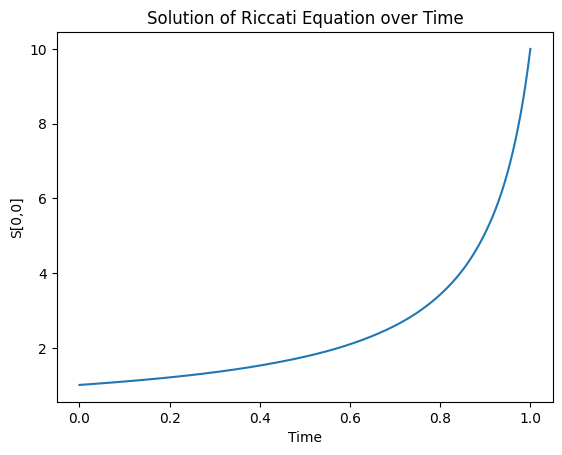

Optimal Markov Control:
tensor([[[-2.5995, -2.5995]]])
Value Function:
tensor([5.1990])


In [3]:
# Example Usage:
# Define problem matrices
# H = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
# M = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
# D = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
# C = torch.tensor([[0, 0], [0, 0]], dtype=torch.float32)
# R = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
# sigma = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
# T = torch.tensor(100, dtype=torch.float32)

#Initial Conditions
H = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)*0.1
M = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
sigma = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)*0.001
D = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
T = torch.tensor(1.0, dtype=torch.float32)
x0 = torch.tensor([1, 1], dtype=torch.float32)
t=torch.tensor(0.7, dtype=torch.float32)
C = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)*0
R = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)*10

# Initialize LQRController
# controller = LQRController(H, M, D, C, R, T)

# Define time grid
time_grid = torch.linspace(0, T, 10000)

lqr_system = LQR(H, M, sigma, C, D, R, T)
S_solution = lqr_system.solve_ricatti_ode(time_grid)
S_sol_v2 = S_solution.T.reshape(len(time_grid),2,2)
S_sol_ordered =torch.flip(S_sol_v2,dims=[0])
lqr_system.visualize_results(torch.flip(time_grid, [0]), S_solution)

# # Create sample input tensors
# t_batch = torch.tensor([0.5, 0.8, 1.0], dtype=torch.float32)  # Sample time values
# x_batch = torch.tensor([
#     [[1.0, 2.0]],  
#     [[1.0, 0.0]], 
#     [[3.0, 2.0]]  
# ], dtype=torch.float32)  # Sample spatial values

t_batch = torch.tensor([0.7], dtype=torch.float32)  # Sample time values
x_batch = torch.tensor([
    [[1.0, 1.0]] 
], dtype=torch.float32)  # Sample spatial values

# Compute the markov control
markov_control = lqr_system.markov_control(t_batch, x_batch)

# Print the computed value function
print("Optimal Markov Control:")
print(markov_control)

# Compute the value function
value_func = lqr_system.value_function(t_batch, x_batch)

# Print the computed value function
print("Value Function:")
print(value_func)



In [4]:
t_batch.shape, x_batch.shape

(torch.Size([1]), torch.Size([1, 1, 2]))

## Exercise 1.2

1. Error

2. Time

In [5]:
#Create error function 
def calculate_error(X1, X2):
    error = (1/len(X1))*(X1-X2)^2
    return error

In [4]:
# Initial Conditions
H = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)*0.1
M = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
sigma = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)*0.001
D = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
T = torch.tensor(1.0, dtype=torch.float32)
x0 = torch.tensor([1, 1], dtype=torch.float32)
t=torch.tensor(0.7, dtype=torch.float32)
C = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)*0
R = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)*10


# Define time grid
time_grid_S = torch.linspace(0, T, 10000)
lqr_system = LQR(H, M, sigma, C, D, R, T)
S_solution = lqr_system.solve_ricatti_ode(time_grid_S)
S_sol_v2 = S_solution.T.reshape(len(time_grid_S),2,2).float()
S_sol_ordered =torch.flip(S_sol_v2,dims=[0])


In [6]:
# X Generation
def generate_x(T, N_steps, H, M, D, S_solution, sigma, x0):

    x0 = torch.tensor(x0, dtype=torch.float32).view(2, 1) 
    tau = T / N_steps
    X = x0.unsqueeze(0)
    brownian = torch.randn(N_steps, 2, dtype=torch.float32)*torch.sqrt(tau)

    for i in range(N_steps-1):
        dw = (brownian[i+1] - brownian[i]).view(2, 1)  # Ensure dw is a 2x1 vector
        # Calculate control action, ensuring it results in a 2x1 vector
        a_s = -torch.inverse(D) @ M.T @ S_sol_ordered[i] @ X[-1]
        # Update state, ensuring result is a 2x1 vector
        next_val = X[-1] + tau * (H @ X[-1] + M @ a_s) + sigma @ dw  # Use matrix-vector product for sigma @ dw
        
        X=torch.cat((X,next_val.view(2, 1).unsqueeze(0))) # Ensure next_val remains a 2x1 column vector

    return X.transpose(1,2)

# Call the function with corrected inputs
N_steps = 100
result = generate_x(T, N_steps, H.float(), M.float(), D.float(), S_solution.float(), sigma.float(), x0)
print(result)

tensor([[[1.0000, 1.0000]],

        [[0.9909, 0.9907]],

        [[0.9818, 0.9817]],

        [[0.9727, 0.9729]],

        [[0.9640, 0.9640]],

        [[0.9553, 0.9552]],

        [[0.9463, 0.9462]],

        [[0.9376, 0.9377]],

        [[0.9291, 0.9291]],

        [[0.9206, 0.9205]],

        [[0.9122, 0.9122]],

        [[0.9038, 0.9039]],

        [[0.8957, 0.8956]],

        [[0.8875, 0.8873]],

        [[0.8792, 0.8792]],

        [[0.8712, 0.8712]],

        [[0.8632, 0.8632]],

        [[0.8554, 0.8553]],

        [[0.8474, 0.8476]],

        [[0.8397, 0.8397]],

        [[0.8321, 0.8319]],

        [[0.8243, 0.8244]],

        [[0.8168, 0.8165]],

        [[0.8093, 0.8093]],

        [[0.8020, 0.8019]],

        [[0.7947, 0.7948]],

        [[0.7870, 0.7873]],

        [[0.7801, 0.7799]],

        [[0.7728, 0.7728]],

        [[0.7658, 0.7657]],

        [[0.7587, 0.7589]],

        [[0.7517, 0.7518]],

        [[0.7451, 0.7448]],

        [[0.7382, 0.7380]],

        [[0.73

/tmp/ipykernel_1463/2947327018.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x0, dtype=torch.float32).view(2, 1)


### Exercise 1.2.1

For our error measure we will use the Mean Squared Error (MSE).  This is a computationally simple function. We take the difference between the model's predictions and the true value, squaring it and averaging it over the dataset. We use this method for calculating the error because it ensures there are no large outliers in the model's calculation because of squaring of the values. This being said, if our model makes one bad prediction, the error is magnifide so one outlier will dramatically impact the error value. 

### Exercise 1.2.2

In [10]:
# 1.2.2 CODE DO NOT RUN IN GITHUB IF USING N_SAMPLES=100000

N_samples=100 #CHANGE FOR LOCAL RUNNING
N_steps=[1, 10, 50, 100, 500, 1000, 5000]
cost=torch.tensor([])
S_sol_cs = CubicSpline(time_grid_S, S_sol_ordered)
exp_cost=torch.tensor([])
for t in range(len(N_steps)):
    time_grid = torch.linspace(0, T, N_steps[t]+1)
    dt= time_grid[1:]-time_grid[:-1]
    S_sol_cs_vals = torch.tensor((S_sol_cs(time_grid.numpy())),dtype=torch.float32)
    for i in range(N_samples):
        result = generate_x(T, N_steps[t]+1, H.float(), M.float(), D.float(), 
                            S_sol_cs_vals.float(), sigma.float(), x0)
        alp = (-torch.inverse(D) @ M.T @ S_sol_cs_vals @result.transpose(1,2)).transpose(1,2)
        int_ = result@C@result.transpose(1,2) + alp@D@alp.transpose(1,2)
        J = torch.tensor(0.5)*dt@((int_.squeeze(1)[1:]+int_.squeeze(1)[:-1]))
        cost=torch.cat((cost,J))
    exp_cost=torch.cat((exp_cost,torch.mean(cost).unsqueeze(0)))

/tmp/ipykernel_1172/2947327018.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x0, dtype=torch.float32).view(2, 1)


KeyboardInterrupt: 

In [9]:
# OUR FIRST 1.2 BABY :D

def calculate_mse(X1, X2):
    count = 0
    MSE = []
    SE = 0

    for i in range(len(X2)):
        SE += (X2.data[i]-X1)**2
        count+=1
    return SE/count


print(calculate_mse(exp_cost, value_func))


#Plot the error
plt.loglog(N_steps, error, marker='o', linestyle='-')
plt.xlabel('Number of Steps')
plt.ylabel('Error (Euclidean Distance from Target)')
plt.title('Error vs. Number of Steps on a Log-Log Scale')
plt.grid(True, which="both", ls="--")
plt.show()

tensor([638.7959, 161.9492,  69.0262,  37.0251,  22.3398,  14.4481,   8.9660])


NameError: name 'error' is not defined

Exercise 1.2.3

In [ ]:
# 1.2.3 CODE DO NOT RUN IN GITHUB IF USING N_SAMPLES=100000

#N_samples=[10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000] #DO NOT RUN
N_samples = [10,50,100,250,500,750,1000]
N_steps = 5000
cost_samples = torch.tensor([])
exp_cost_samples = torch.tensor([])

# Time grid specifications
time_grid = torch.linspace(0, T, N_steps+1)
dt = time_grid[1:]-time_grid[:-1]
S_sol_cs_vals = torch.tensor((S_sol_cs(time_grid.numpy())),dtype=torch.float32)

for j in range(len(N_samples)):
    for i in range(N_samples[j]):
        result = generate_x(T, N_steps+1, H.float(), M.float(), D.float(), 
        S_sol_cs_vals.float(), sigma.float(), x0)

        alp = (-torch.inverse(D) @ M.T @ S_sol_cs_vals @result.transpose(1,2)).transpose(1,2)
        int_ = result@C@result.transpose(1,2) + alp@D@alp.transpose(1,2)

        J = result[-1]@R@result[-1].T + torch.tensor(0.5)*dt@((int_.squeeze(1)[1:]+int_.squeeze(1)[:-1]))
        cost_samples=torch.cat((cost_samples,J))
    
    exp_cost_samples=torch.cat((exp_cost_samples,torch.mean(cost_samples).unsqueeze(0)))

NameError: name 'S_sol_cs' is not defined

tensor([5.1072, 5.1072, 5.1072, 5.1072, 5.1072, 5.1072, 5.1072])


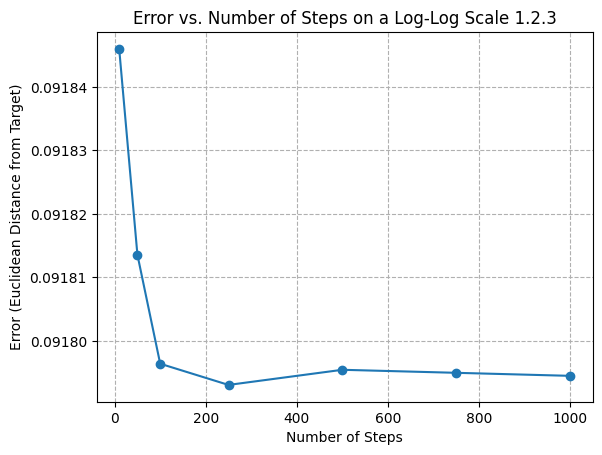

In [ ]:
# OUR FIRST 1.2.3 BABY :D

print(exp_cost_samples) # why is the first one better than the second?

# Compute the error
error_samples = abs(exp_cost_samples-value_func)

#Plot the error
plt.plot(N_samples, error_samples, marker='o', linestyle='-')
plt.xlabel('Number of Steps')
plt.ylabel('Error (Euclidean Distance from Target)')
plt.title('Error vs. Number of Steps on a Log-Log Scale 1.2.3')
plt.grid(True, which="both", ls="--")
plt.show()

Exercise 2

In [7]:
# Function to generate training data
def generate_training_data(T, num_samples):
    t = torch.tensor(np.random.uniform(0, T, num_samples), dtype=torch.float32)
    x = torch.tensor(np.random.uniform(-3, 3, (num_samples, 2)), dtype=torch.float32).unsqueeze(-1).transpose(1,2)
    return t, x

In [13]:
def train_net_dgm(net_dgm, t_train, x_train, epochs=1000, lr=1e-2):
    """
    Function to train a neural network `net_dgm` for value function 
    prediction using training data `t_train` and `x_train`.

    Args:
        net_dgm (torch.nn.Module): The neural network model to train.
        t_train (torch.Tensor): Input time data tensor.
        x_train (torch.Tensor): Input state data tensor.
        epochs (int): Number of training epochs.
        lr (float): Initial learning rate.

    Returns:
        losses (np.array): Array of loss values during training.
    """
    # Initialize optimizer, criterion, and an empty array to store loss values
    optimizer = optim.Adam(net_dgm.parameters(), lr=lr)
    criterion = nn.MSELoss()
    losses = np.array([])

    # Learning rate scheduler: Reduce learning rate by a factor of 0.2 every 100 epochs
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.2)

    # Training loop
    for epoch in range(epochs):
        optimizer.zero_grad()

        # Compute the real value function based on training data
        v_real = lqr_system.value_function(t_train, x_train).unsqueeze(1)

        # Forward pass: Predict value function using the neural network
        v_pred = net_dgm(t_train.unsqueeze(1), x_train.view(-1, 2))  # Adjust input shape if necessary

        # Compute the loss between predicted and real value functions
        loss = criterion(v_pred, v_real)

        # Backpropagation: Compute gradients and update model parameters
        loss.backward()
        optimizer.step()

        # Append the current loss value to the losses array
        losses = np.append(losses, loss.item())

        # Update learning rate based on the scheduler
        scheduler.step()

        # Print the loss value every 100 epochs
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    return losses


Epoch 0, Loss: 227.58984375
Epoch 100, Loss: 0.0002627844223752618
Epoch 200, Loss: 2.752456707000306e-09
Epoch 300, Loss: 5.645261818773561e-13
Epoch 400, Loss: 3.7410076121971447e-13


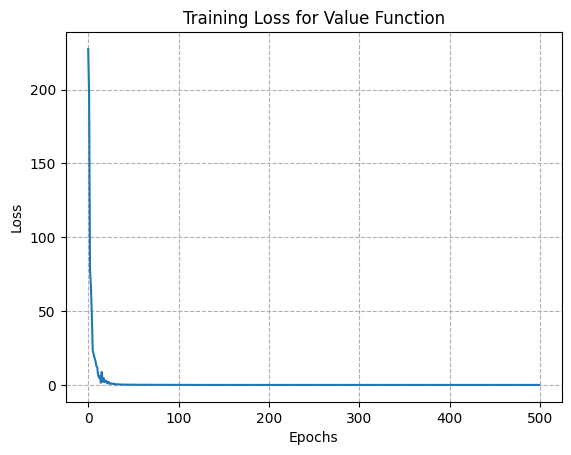

In [14]:
# Generate training data
T = 1.0
num_samples = 100
t_train, x_train = generate_training_data(T, num_samples)

# Initialize the neural network (adjust based on your network architecture)
net_dgm = Net_DGM(dim_x=2, dim_S=100, hidden_size=100)

# Train the neural network with hyperparameter scheduling
losses = train_net_dgm(net_dgm, t_train, x_train, epochs=1000, lr=1e-2)

# Plot the training loss
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss for Value Function')
plt.grid(ls='--')
plt.show()

In [15]:
# do we need this?
print(lqr_system.solve_ricatti_ode(time_grid).T.reshape(len(time_grid),2,2).float())

tensor([[[10.0000,  0.0000],
         [ 0.0000, 10.0000]],

        [[ 9.9902,  0.0000],
         [ 0.0000,  9.9902]],

        [[ 9.9804,  0.0000],
         [ 0.0000,  9.9804]],

        ...,

        [[ 1.0147,  0.0000],
         [ 0.0000,  1.0147]],

        [[ 1.0147,  0.0000],
         [ 0.0000,  1.0147]],

        [[ 1.0146,  0.0000],
         [ 0.0000,  1.0146]]])


Epoch 0, Loss: 50.851741790771484
Epoch 100, Loss: 0.014009739272296429
Epoch 200, Loss: 0.006299708969891071
Epoch 300, Loss: 0.005095827393233776
Epoch 400, Loss: 0.0048381066881120205
Epoch 500, Loss: 0.0047800252214074135
Epoch 600, Loss: 0.004766966216266155
Epoch 700, Loss: 0.004764075856655836
Epoch 800, Loss: 0.004763538483530283
Epoch 900, Loss: 0.004763494711369276


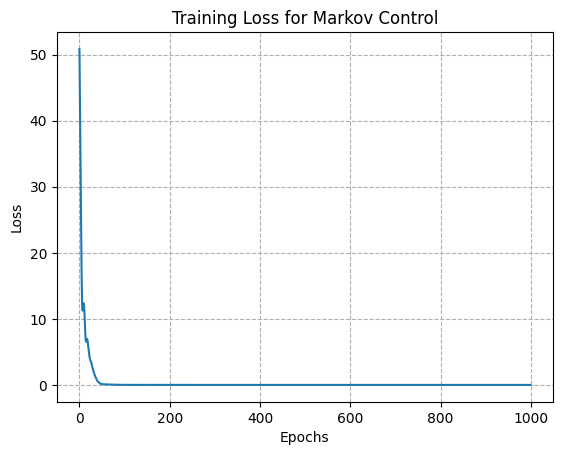

In [22]:
def train_ffn_net(net_ffn, t_train, x_train, epochs=1000, lr=1e-2):
    """
    Function to train a feedforward neural network `net_ffn` for Markov 
    control prediction using training data `t_train` and `x_train`.

    Args:
        net_ffn (torch.nn.Module): The feedforward neural network model to train.
        t_train (torch.Tensor): Input time data tensor.
        x_train (torch.Tensor): Input state data tensor.
        epochs (int): Number of training epochs.
        lr (float): Initial learning rate.

    Returns:
        losses (list): List of loss values during training.
    """
    # Initialize optimizer, concatenate time and state tensors for input to the network
    optimizer = optim.Adam(net_ffn.parameters(), lr=lr)
    tx_train = torch.cat((t_train.unsqueeze(1), x_train.squeeze(1)), dim=1)
    criterion = nn.MSELoss()

    # Initialize an empty list to store loss values
    losses = []

    # Learning rate scheduler: Reduce learning rate by a factor of 0.2 every 100 epochs
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.2)

    # Training loop
    for epoch in range(epochs):
        optimizer.zero_grad()

        # Compute the real Markov control based on training data
        a_real = lqr_system.markov_control(t_train, x_train).squeeze(1)

        # Forward pass: Predict Markov control using the neural network
        input_data = torch.cat((t_train.unsqueeze(1), x_train.view(-1, 2)), dim=1)
        a_pred = net_ffn(input_data)

        # Compute the loss between predicted and real Markov control
        loss = criterion(a_pred, a_real)

        # Backpropagation: Compute gradients and update model parameters
        loss.backward()
        optimizer.step()

        # Append the current loss value to the losses list
        losses.append(loss.item())

        # Update learning rate based on the scheduler
        scheduler.step()

        # Print the loss value every 100 epochs
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    return losses



In [23]:
# Generate training data
T = 1
num_samples = 100
t_train, x_train = generate_training_data(T, num_samples)

# Define the sizes for the FFN network
sizes = [3, 100, 100, 2]  # Input size is 3 (time + 2 x), 2 hidden layers of size 100, output size is 2 (Markov control)

# Initialize the feedforward neural network (adjust based on your network architecture)
net_ffn = FFN(sizes)

# Train the feedforward neural network with hyperparameter scheduling
losses = train_ffn_net(net_ffn, t_train, x_train, epochs=1000, lr=1e-2)

# Plot the training loss
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss for Markov Control')
plt.grid(ls='--')
plt.show()

Epoch 0, Loss: 39.46620559692383


KeyboardInterrupt: 

In [8]:
a_real=lqr_system.markov_control(t_train, x_train).squeeze(1)
tx_train = torch.cat((t_train.unsqueeze(1),x_train.squeeze(1)),dim=1)
a_real,tx_train

(tensor([[-3.2860,  1.7188],
         [ 1.8760, -2.5800],
         [-2.1910, -2.5670],
         [ 1.9268,  4.2963],
         [ 2.9776,  1.6693],
         [ 5.0712, -6.8930],
         [-2.6924,  0.5434],
         [-0.1176,  1.7335],
         [-2.5575, -3.0802],
         [ 2.9352,  0.6273]]),
 tensor([[ 0.1513,  2.8354, -1.4831],
         [ 0.3501, -1.3048,  1.7945],
         [ 0.5410,  1.1583,  1.3571],
         [ 0.4695, -1.1406, -2.5433],
         [ 0.7287, -1.0664, -0.5978],
         [ 0.6471, -2.1946,  2.9829],
         [ 0.2946,  2.0005, -0.4038],
         [ 0.0333,  0.1128, -1.6620],
         [ 0.0911,  2.3320,  2.8087],
         [ 0.4610, -1.7593, -0.3760]]))

## Exercise 3

In [5]:
class PDE():
    def __init__(self, net, T, sigma, H, M, C, D, R, alpha):
        self.net = net
        self.T = T
        self.sigma = sigma
        self.H = H
        self.M = M
        self.C = C
        self.D = D
        self.R = R
        self.alpha = alpha
    
    def pde_residual(self, t, x):
        t.requires_grad_(True)
        x.requires_grad_(True)
        
        u = self.net(t, x)  
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]

        # Compute the trace term
        trace_term = 0.5 * torch.trace(torch.matmul(self.sigma, self.sigma.T)) * u_xx.sum(dim=1, keepdim=True)  # (batch, 1)
        t1 = (u_x @ self.H @ x.T).sum(dim=1).unsqueeze(1)
        # t1 = torch.matmul(u_x, torch.matmul(self.H, x.reshape(num_samples, 2, 1))).reshape(num_samples, 1)
        t2 = (torch.matmul(u_x, torch.matmul(self.M, self.alpha.T))).T.unsqueeze(1)
        x = x.unsqueeze(1).detach()
        # t3 = (torch.matmul(x, torch.matmul(self.C, x.T)).sum(dim=1)).unsqueeze(1)
        t3 = torch.matmul(x, torch.matmul(self.C, x.reshape(num_samples, 2, 1))).reshape(num_samples, 1)
        t4 = torch.matmul(self.alpha.T, torch.matmul(self.D, self.alpha)).expand_as(trace_term)

        # Compute the PDE residual term
        pde_res = (
            u_t + trace_term + t1 + t2 + t3 + t4
        )

        return pde_res


    def boundary_condition(self, x):
        # Compute the boundary condition term
        T = torch.full_like(x[:, :1], self.T.item())  # Create a tensor of the same size as x with values T
        u_final = self.net(T, x)  # Evaluate the neural network output at the final time T
        # R = torch.cat([self.R.unsqueeze(0) for i in range(num_samples)], dim=0)
        x = x.unsqueeze(1).detach()
        cond = torch.matmul(x, torch.matmul(self.R, x.reshape(num_samples, 2, 1))).reshape(num_samples, 1)
        return u_final - cond



In [6]:
class DGM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DGM, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim) 
        self.activation = nn.Tanh()

    def forward(self, t, x):
        input_tensor = torch.cat((t, x), dim=1)
        hidden1 = self.activation(self.fc1(input_tensor))
        hidden2 = self.activation(self.fc2(hidden1))
        hidden3 = self.activation(self.fc3(hidden2)) 
        output = self.fc4(hidden3)
        return output

def loss_function(u, t, x, linear_pde):
    pde_residual = linear_pde.pde_residual(t, x)
    boundary_term = linear_pde.boundary_condition(x)
    
    # Compute MSE loss
    pde_loss = F.mse_loss(pde_residual, torch.zeros_like(pde_residual))
    boundary_loss = F.mse_loss(boundary_term, torch.zeros_like(boundary_term))
    
    # Total loss is the sum of MSE losses
    loss = pde_loss + boundary_loss
    return loss    


def train_dgm(model, t_train, x_train, linear_pde, epochs, lr, lr_decay_factor=0.1, lr_decay_epochs=500):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_epochs, gamma=lr_decay_factor)
    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        u_pred = model(t_train, x_train)
        loss = loss_function(u_pred, t_train, x_train, linear_pde)
        loss.backward()
        torch_utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        losses.append(loss.item())  # Store the loss value
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
            # print(f"learning rate: {scheduler.get_last_lr()[0]}")

    # Calculate normalized losses
    losses = [loss / len(t_train) for loss in losses]

    return losses



In [7]:
# Define hyperparameters
input_dim = 3  # Input dimension (time, space_x, space_y)
hidden_dim = 150 # Hidden layer dimension
output_dim = 1  # Output dimension (solution)
num_samples = 100  # Number of training samples
T = torch.tensor([1], dtype=torch.float32)  # End time
epochs = 1500  # Number of training epochs
lr = 1e-2  # Learning rate
alpha = torch.tensor([1.0, 1.0], dtype=torch.float32)
lr_decay_factor = 0.2  # Factor by which the learning rate is reduced
lr_decay_epochs = 200  # Number of epochs after which the learning rate is reduced

# Initialize the DGM model
model = DGM(input_dim, hidden_dim, output_dim)

# Create an instance of the PDE class
linear_pde = PDE(model, T, sigma, H, M, C, D, R, alpha)

# Generate training data
t_train = torch.rand(num_samples, 1) * T
x_train = torch.rand(num_samples, 2)  # Assuming 2D space

# Train the DGM model
losses = train_dgm(model, t_train, x_train, linear_pde, epochs, lr, lr_decay_factor, lr_decay_epochs)


/tmp/ipykernel_28276/3484406952.py:26: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3637.)
  t2 = (torch.matmul(u_x, torch.matmul(self.M, self.alpha.T))).T.unsqueeze(1)


Epoch 0, Loss: 66.30754089355469
Epoch 100, Loss: 15.756382942199707
Epoch 200, Loss: 0.9214127063751221
Epoch 300, Loss: 0.9142239689826965
Epoch 400, Loss: 0.17163996398448944
Epoch 500, Loss: 0.0512610599398613
Epoch 600, Loss: 0.025641027837991714
Epoch 700, Loss: 0.013453107327222824
Epoch 800, Loss: 0.009824427776038647
Epoch 900, Loss: 0.008970732800662518
Epoch 1000, Loss: 0.008256933651864529
Epoch 1100, Loss: 0.008118974044919014
Epoch 1200, Loss: 0.007977123372256756
Epoch 1300, Loss: 0.007947670295834541
Epoch 1400, Loss: 0.00791691243648529


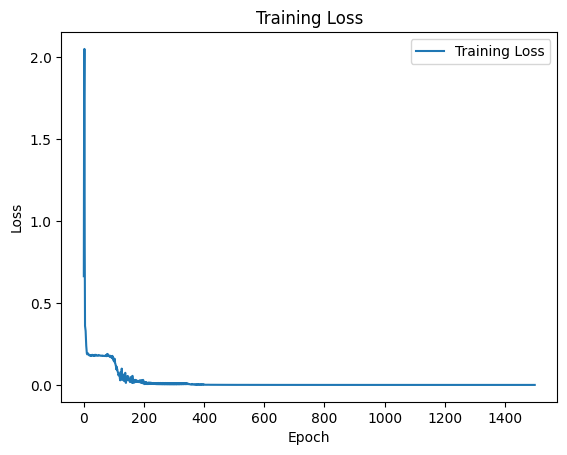

In [8]:
# Plot the losses
plt.plot(range(epochs), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [ ]:
# Function to compute the error between the model prediction and Monte Carlo solution
def compute_error(model, t, x, alpha, R):
    u_pred = model(t, x)
    mc_solution = monte_carlo_solution(x, alpha, R)
    error = torch.abs(u_pred - mc_solution)
    return error


# Plot the error against the Monte Carlo solution
plt.subplot(1, 2, 2)
plt.plot(range(0, epochs, interval), errors, label='Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error against Monte Carlo Solution')
plt.legend()

plt.tight_layout()
plt.show()

Exercise 4

In [47]:
class ValueFunction(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ValueFunction, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim) 
        self.activation = nn.Tanh()

    def forward(self, t, x):
        input_tensor = torch.cat((t, x), dim=1)
        hidden1 = self.activation(self.fc1(input_tensor))
        hidden2 = self.activation(self.fc2(hidden1))
        hidden3 = self.activation(self.fc3(hidden2)) 
        output = self.fc4(hidden3)
        return output

class ControlFunction(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ControlFunction, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim) 
        self.activation = nn.Tanh()
    
    def forward(self, t, x):
        input_tensor = torch.cat((t, x), dim=1)
        hidden1 = self.activation(self.fc1(input_tensor))
        hidden2 = self.activation(self.fc2(hidden1))
        hidden3 = self.activation(self.fc3(hidden2)) 
        output = self.fc4(hidden3)
        return output


In [48]:
class PDE_PIA:
    def __init__(self, net_val, net_act, T, sigma, H, M, C, D, R):
        self.net_val = net_val  # Value function approximation network
        self.net_act = net_act  # Control function approximation network
        self.T = T
        self.sigma = sigma
        self.H = H
        self.M = M
        self.C = C
        self.D = D
        self.R = R
    
    def pde_residual(self, t, x):
        t.requires_grad_(True)
        x.requires_grad_(True)
        
        u = self.net_val(t, x)  
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]

        # Compute the trace term
        trace_term = 0.5 * torch.trace(torch.matmul(self.sigma, self.sigma.T)) * u_xx.sum(dim=1, keepdim=True)  # (batch, 1)
        t1 = (u_x @ self.H @ x.T).sum(dim=1).unsqueeze(1)
        t2 = (u_x @ (self.M @ self.net_act(t, x).T)).sum(dim=1, keepdim=True)
        t3 = (x @ self.C @ x.T).sum(dim=1).unsqueeze(1)
        t4 = (self.net_act(t, x) @ self.D @ self.net_act(t, x).T).sum(dim=1, keepdim=True)

        
        pde_res = (
            u_t + trace_term + t1 + t2 + t3 + t4
        )

        return pde_res

    def boundary_condition(self, x):
        # Compute the boundary condition term
        T = torch.full_like(x[:, :1], self.T.item())  # Create a tensor of the same size as x with values T
        u_final = self.net_val(T, x)  # Evaluate the neural network output at the final time T
        # R = torch.cat([self.R.unsqueeze(0) for i in range(num_samples)], dim=0)
        x = x.unsqueeze(1).detach()
        cond = torch.matmul(x, torch.matmul(self.R, x.reshape(num_samples, 2, 1))).reshape(num_samples, 1)
        return u_final - cond

    def loss_function(self, t_train, x_train):
        pde_residual = self.pde_residual(t_train, x_train)
        boundary_res = self.boundary_condition(x_train)
        
        # Compute MSE loss
        pde_loss = F.mse_loss(pde_residual, torch.zeros_like(pde_residual))
        boundary_loss = F.mse_loss(boundary_res, torch.zeros_like(boundary_res))
        
        # Total loss is the sum of MSE losses
        loss = pde_loss + boundary_loss
        
        return loss    

    def update_value_function(self, optimizer_val, t_train, x_train):
        optimizer_val.zero_grad()
        pde_residual = torch.abs(self.pde_residual(t_train, x_train))
        boundary_res = torch.abs(self.boundary_condition(x_train))

        # Compute MSE loss
        pde_loss = F.mse_loss(pde_residual, torch.zeros_like(pde_residual))
        boundary_loss = F.mse_loss(boundary_res, torch.zeros_like(boundary_res))
        
        # Total loss is the sum of MSE losses
        loss = pde_loss + boundary_loss

        loss.backward()
        optimizer_val.step()
        
        return loss
    

    def update_control_function(self, optimizer_act, t_train, x_train):
        optimizer_act.zero_grad()

        # Compute the output of net_val at (t_train, x_train)
        u = self.net_val(t_train, x_train)

        # Compute the gradients of u with respect to x_train
        u_x = torch.autograd.grad(u, x_train, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        
        # Compute the Hamiltonian
        h1 = (u_x @ self.H @ x_train.T)
        h2 = u_x @ self.M @ self.net_act(t_train, x_train).T
        h3 = x_train @ self.C @ x_train.T
        h4 = self.net_act(t_train, x_train) @ self.D @ self.net_act(t_train, x_train).T

        hamiltonian = h1 + h2 + h3 + h4

        # Minimize the mean of the Hamiltonian
        loss = torch.mean(hamiltonian)

        # Backpropagation and optimization step
        loss.backward()
        optimizer_act.step()

        return loss.item()


def policy_iteration(net_val, net_act, pde, t_train, x_train, epochs_val, epochs_act, lr_val, lr_act, lr_decay_epochs, lr_decay_factor):
    optimizer_val = optim.Adam(net_val.parameters(), lr=lr_val)
    optimizer_act = optim.Adam(net_act.parameters(), lr=lr_act)
    
    scheduler_val = StepLR(optimizer_val, step_size=lr_decay_epochs, gamma=lr_decay_factor)
    scheduler_act = StepLR(optimizer_act, step_size=lr_decay_epochs, gamma=lr_decay_factor)
    losses_val = []
    losses_act = []

    print(f"Value Function Update\n---------------------")
    for epoch in range(epochs_val):
        optimizer_val.zero_grad()
        loss_val = pde.loss_function(t_train, x_train)
        loss_val.backward()
        torch_utils.clip_grad_norm_(net_val.parameters(), 1.0)
        optimizer_val.step()
        scheduler_val.step()
        losses_val.append(loss_val.item())  # Store the loss value
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss = {loss_val.item()}')

    print(f"-----------------------\nControl Function Update\n-----------------------")
    for epoch in range(epochs_act):
        loss_act = pde.update_control_function(optimizer_act, t_train, x_train)
        scheduler_act.step()  # Update learning rate
        losses_act.append(loss_act)
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Control Function Update: Loss = {loss_act}, Learning Rate = {scheduler_act.get_last_lr()}')

    return losses_val, losses_act

# Initialize value function and control function networks
net_val = ValueFunction(input_dim=3, hidden_dim=150, output_dim=1)
net_act = ControlFunction(input_dim=3, hidden_dim=150, output_dim=2)

T = torch.tensor([1], dtype=torch.float32)
# Initialize PDE solver with networks and other parameters
pde = PDE_PIA(net_val, net_act, T, sigma, H, M, C, D, R)

# Generate training data (sampled from [0, T) x R^2)
t_train = torch.rand(num_samples, 1) * pde.T
x_train = torch.rand(num_samples, 2)

# Hyperparameters for learning rate scheduler
lr_decay_epochs = 200
lr_decay_factor = 0.2

# Run policy iteration algorithm with learning rate scheduler
losses_val, losses_act = policy_iteration(net_val, net_act, pde, t_train, x_train, epochs_val=1000, epochs_act=1000, lr_val=1e-2, lr_act=1e-2, 
                                          lr_decay_epochs=lr_decay_epochs, lr_decay_factor=lr_decay_factor)


Value Function Update
---------------------
Epoch 0, Loss = 76.47377014160156
Epoch 100, Loss = 0.9030964970588684
Epoch 200, Loss = 0.46106383204460144
Epoch 300, Loss = 0.06010189652442932
Epoch 400, Loss = 0.0998266264796257
Epoch 500, Loss = 0.00889916904270649
Epoch 600, Loss = 0.006024624221026897
Epoch 700, Loss = 0.005594121292233467
Epoch 800, Loss = 0.005179451312869787
Epoch 900, Loss = 0.005100558511912823
-----------------------
Control Function Update
-----------------------
Epoch 0, Control Function Update: Loss = -0.07565201073884964, Learning Rate = [0.01]
Epoch 100, Control Function Update: Loss = -6.332071304321289, Learning Rate = [0.01]
Epoch 200, Control Function Update: Loss = -6.332118988037109, Learning Rate = [0.002]
Epoch 300, Control Function Update: Loss = -6.332118988037109, Learning Rate = [0.002]
Epoch 400, Control Function Update: Loss = -6.332118988037109, Learning Rate = [0.0004]
Epoch 500, Control Function Update: Loss = -6.332118988037109, Learning 

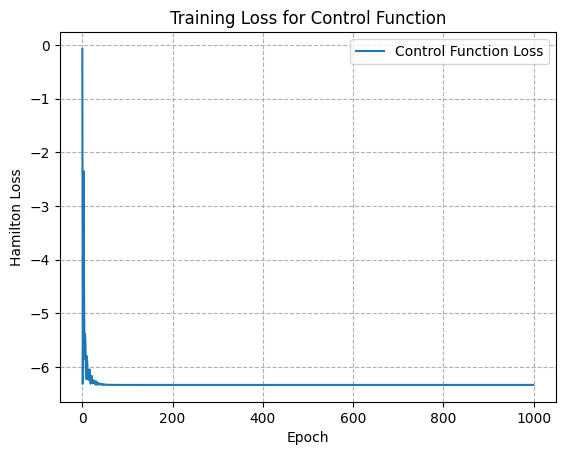

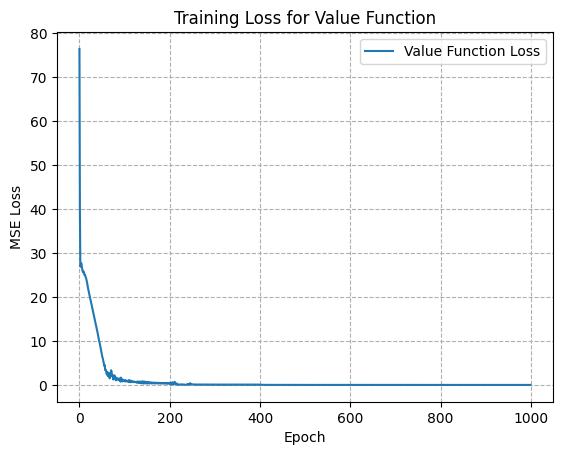

In [49]:
# Plotting the training losses
plt.plot(range(len(losses_act)), losses_act, label='Control Function Loss')
plt.xlabel('Epoch')
plt.ylabel('Hamilton Loss')
plt.title('Training Loss for Control Function')
plt.legend()
plt.grid(linestyle='dashed')
plt.show()

plt.plot(range(len(losses_val)), losses_val, label='Value Function Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss for Value Function')
plt.legend()
plt.grid(linestyle='dashed')
plt.show()